# Online Search Trends (Illustrative)

Knowing what people are searching online or the change in their searching patterns can be used to understand people's behavior or needs after a crisis. Google Trends is an API that allows users to obtain data about what people searched online in real time and in the past for a region of interest. This dataset has been widely used for monitoring COVID-19 outbreak, for understanding goods shortages, etc. 

This notebook shows how to work with Google Trends data through an example that leverages this data to understand the impact of Morocco's 2023 earthquake to tourism. 

## Learning Objectives
### Overall goals
The main goal of this class is for students to understand Google Trends data and how it can be leveraged for economic monitoring. 

### Specific goals
1. **Understand Google Trends data**:
   - Introduce the dataset and its different forms.
   - Present the different filters that can be applied to the obtained disaggregated datasets.
2. **Analyze Google Trends data**:
   - Learn how to access the data.
   - Define the filters for a particular problem.
   - Visualize the data across the years.
   - Predict search term behavior.
3. **Apply Google Trends data**:
   - Study the earthquake impact on the tourism industry .
   - Detect population's needs after the earthquake.

## About the data
Google Trends provides a random sample of aggregated, anonymized, and categorized Google and YouTube searches. It lets you analyze interest in a particular query or topic from around the globe or at city-level geography.
<p style="text-align: right;">
  <a href="https://developers.google.com/search/docs/monitor-debug/trends-start">Source</a>.
</p>
The values obtained from Google Trends are not search volumes. The data is normalized to make comparisons between terms easier. Search results are normalized to the time and location of a query by the following process:

- Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity. Otherwise, places with the most search volume would always be ranked highest.

- The resulting numbers are then scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics. (Applies only to public tool).

- Different regions that show the same search interest for a term don't always have the same total search volumes.
<p style="text-align: right;">
  <a href="https://support.google.com/trends/answer/4365533?hl=en#:~:text=Google%20Trends%20normalizes%20search%20data,represents%20to%20compare%20relative%20popularity">Source</a>.
</p>

The data can be accessed for free through [Trends Explore Tool](https://trends.google.com/trends/?geo=US) or through their API if you have an agreement with Google. 

The search in Google Trends can be done by adjusting:
- **Country**: Where the searches are being done.
- **Date range**: It can be from today till 2004.
- **Terms or Topics**: Terms, like for any other Google search are the terms to look for. Topics, on the other hand, are generally considered to be more reliable for Google Trends data. They pull in the exact phrase as well as misspellings and acronyms, and cover all languages. This is more useful, particularly when looking at world data. More information about this data can be found in the [Basics of Google Trends](https://newsinitiative.withgoogle.com/resources/trainings/google-trends/basics-of-google-trends/).
- **Categories**: For example, All, Art and Entertainment, Real Estate, etc.
- **Where to search**: Web Search/Images Search/News Search/Google Shopping/YouTube Search.

As an example, we downloaded Google Trends data for Simone Biles from 2004 till now. It can be seen that every four years, the olympiad span, her name gets more relevance. 

```{figure} ../images/simone_biles.png
---
width: 800px
---
Google Trends Tool result for "Simone Biles".
```


## Methodology for analyzing Google Trends- Moroccos's 2023 Earthquake Response

The following code will show you how to access and analyze Google Trends data using the methodology the Data Lab used for Morocco's 2023 earthquake response. The analysis was performed days after September 2023 Morocco's earthquake happened. It tries to answer two questions:

- Will the earthquake have an impact on the tourism industry?
- Is there a change in search patterns for basic need services after the earthquake?



### Impact on the Tourism Industry
This part of the analysis focused on 5 countries in specific, the ones that make up for the highest number of visitors in Morocco: **France**, **Germany**, **Spain**, **United Kingdom**, **United States**. Thus, a list of commonly used terms that people tend to use to plan their holidays was created. The kinds of searches that users perform can be a good proxy for the public’s interests, concerns or intentions, but these searches do not necessarily represent users’ opinions. Therefore, the analysis uses statistical methods to come up with a probabilistic analysis of impact on Morocco's tourism industry.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime as dt

from googleapiclient.discovery import build

from statsmodels.tsa.filters.hp_filter import hpfilter
import scipy.stats as stats

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error 
from math import sqrt 

import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

The following code uses Classes and Methods. If you are not familiar with this programming methodology, you can find more by searching for Object Oriented Programming (OOP). 

The Class Google, as stated in its documentation, is used for handling the authentication and requests to Google API. You will need to save your Google API key as an environmental variable named `GOOGLE_TOKEN` in order to be correctly authenticated.

In [2]:
class Google():
    """
    Wrapper class for handling authentication and requests (GET) to Google API
    
    Parameters
    ----------
    token : str
        Google API token
        
    Notes
    -----
    For more information, please see https://developers.google.com/apis-explorer
    """
    
    def __init__(self, token=None):
        self.TOKEN = token if token else os.getenv("GOOGLE_TOKEN")
        
    @property
    def service(self):
        """Authenticate and instantiate Google API service"""
        return build('trends', 'v1beta', static_discovery=False, developerKey=self.TOKEN)

    def get(self, method, params):
        """Get result from Google API method"""
        return getattr(self.service, method)(**params).execute()
    
    
    # def download(self, method, params):
    #     """Download result from Google API method"""
    #     import pdb; pdb.set_trace()
        
    #     if not method in ["getGraph", "getTimelinesForHealth"]:
    #         raise NotImplementedError("Method not supported.")
        
    #     result = self.get(method, params)
        
    #     df = pd.json_normalize(result["lines"], meta=["term"], record_path=["points"]) 
        
    #     params = "+".join([f"{k}={v}" for k, v in params.items()])
    #     name = f"{method}+{params}.csv"

    #     df.to_csv(name, index=False)

In [3]:
# Instantiate your Google class to start querying
google = Google()

##### Lists of commonly used travel search terms in different languages catering to United States, United Kingdom, France, Germany and Spain. 

In [4]:
eng_terms = ['morocco flights', 'morocco hotels', 'marrakesh', 'marrakesh hotels', 'casablanca morocco','casablanca hotels', 
         'casablanca flights', 'casablanca travel', 'morocco tourist attractions', 'things to do in morocco', 'things to do in casablanca',
         "moroccan cuisine", "beaches in morocco", "Safety in Morocco", "transportation in Morocco"]

In [5]:
french_terms = ['séjour à marrakech', "vacance maroc", "voyages marrakech", "billet avion Maroc", "casablanca hotels", "marrakech hotels",
                "Cuisine marocaine", "Sécurité au Maroc"]

In [6]:
spanish_terms = ['Vuelos a Marruecos', 'Hoteles en Marruecos', 'Casablanca Marruecos', 'Hoteles en Casablanca', 'Vuelos a Casablanca', 'Viaje a Marruecos', 'Que hacer en Marruecos',
                 "Rutas por Marruecos", "Playas en Marruecos", "Seguridad en Marruecos"]

In [7]:
german_terms = ['Marokko Hotels', 'Hotels in Marrakesch', "things to do in morocco", "Pauschalreisen Marokko", "Marokko Sehenswürdigkeiten",
                "Marokko Rundreise", "Marokko Strände", "Marokko Sicherheit", "Marokko Transport"]

In [8]:
con_dict = {"US" :  "United States", "GB" : "United Kingdom", "ES" : "Spain", "FR" : "France", "DE" : "Germany"}

In [9]:
def get_df(terms, country, start_date = None, end_date = None):
    """
    Function to get a dataframe for specified list of terms, country iso2 code and start/end date strings

    Return:
    Pandas Dataframe
    """
    df = pd.DataFrame()
    for term in terms:
        filters = {
            'terms': [term],
            'restrictions_geo': country,
            'restrictions_startDate': start_date,
            'restrictions_endDate' : end_date
        }

        r = google.get('getGraph', filters)
        df_ = pd.DataFrame(r["lines"][0]["points"])
        df_['query'] = term

        df = pd.concat([df, df_], axis = 0)

    return df

In [10]:
def trenddetector(list_of_index, array_of_data, order=1):
    """
    Helper function to detect upward or downward trend in time series using `order` degree polynomial function

    Returns:
    Slope of the polynomial function 
    """
    result = np.polyfit(list_of_index, list(array_of_data), order)
    slope = result[-2]
    return float(slope)

def get_country_df(country, start_date, end_date = None):
    """
    Function to retrieve country level data for each of the search terms and return an aggregated Dataframe

    Returns:
    Pandas Dataframe
    """

    if country in ['US', 'GB']:
        df = get_df(eng_terms, country, start_date, end_date)
    elif country == 'FR':
        df = get_df(french_terms, country, start_date, end_date)
    elif country == 'ES':
        df = get_df(spanish_terms, country, start_date, end_date)
    elif country == 'DE':
        df = get_df(german_terms, country, start_date, end_date)

    df_grp = df.groupby(['date'])[['value']].mean()

    return df_grp


This example downloads the data from January 2023 till the 12th of November 2023 when the analysis was performed.

In [11]:
df2023 = pd.DataFrame()
for country in ['US', 'GB', 'FR', 'ES', 'DE']:
    df_ = get_country_df(country, "2023-01", "2023-09")

    df_['country'] = con_dict[country]

    df2023 = pd.concat([df2023, df_])
df2023['month'] = [dt.strptime(i, "%Y-%m-%d").strftime("%b-%d") for i in df2023.index]

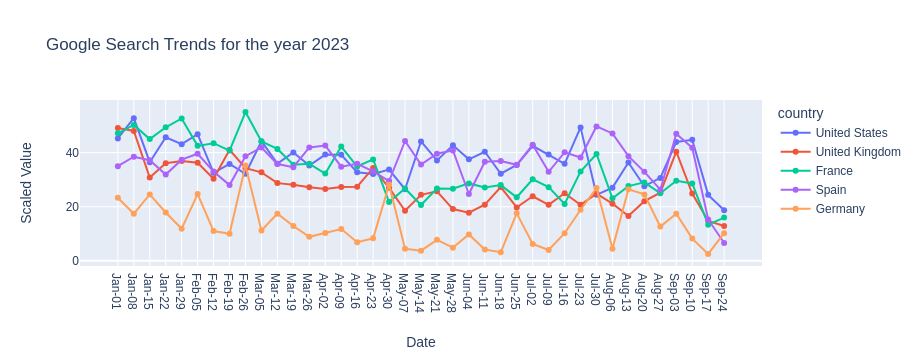

In [12]:
fig = px.line(df2023, x='month', y='value', color='country', markers=True, title = f"Google Search Trends for the year 2023")
fig.update_yaxes(
        title_text = "Scaled Value",
        title_standoff = 25)
fig.update_xaxes(
        title_text = "Date",
        title_standoff = 25)

fig.show()

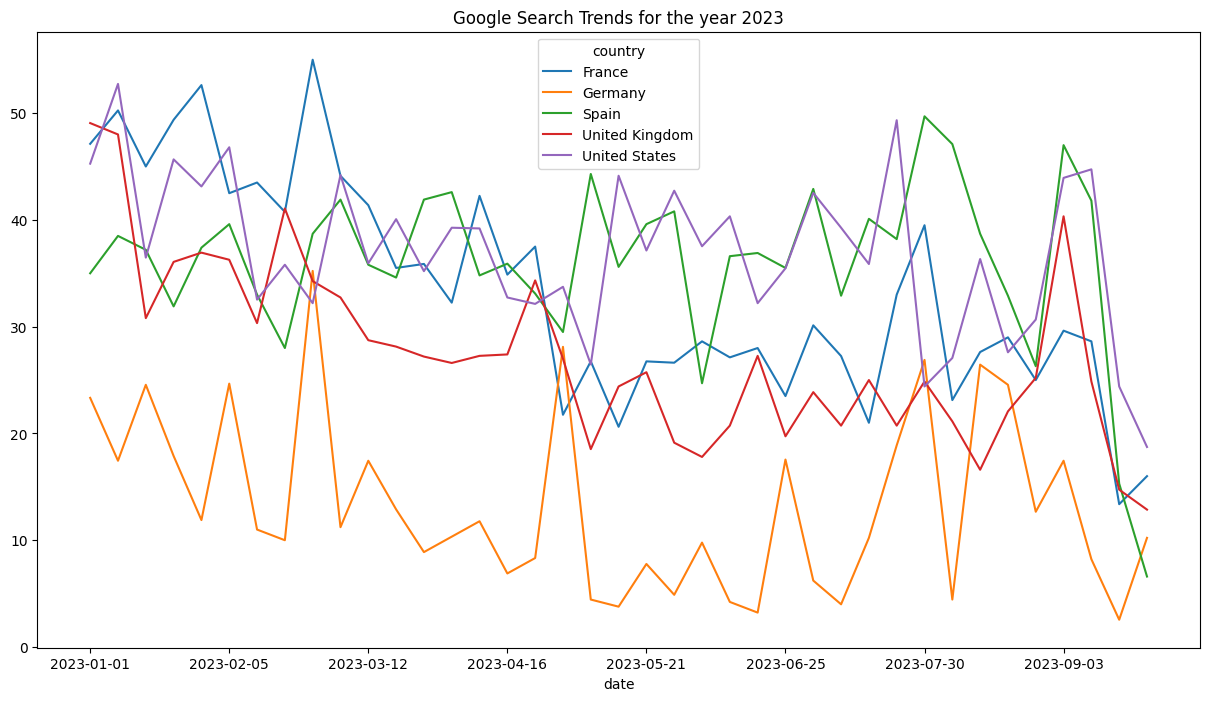

In [13]:
ax = df2023.reset_index().pivot(index = 'date', columns = 'country', values = 'value').plot(figsize = (15, 8))
ax.set_title("Google Search Trends for the year 2023", fontsize = 12);

##### Comparing the trends for the past 3 years for the same time period (Jan - Sep)

In [18]:
def download_several_countries(list_countries, period_start, period_end):
    df = pd.DataFrame()
    for country in list_countries:
        df_ = get_country_df(country, period_start, period_end)
    
        df_['country'] = con_dict[country]
    
        df = pd.concat([df, df_])
    df['month'] = [dt.strptime(i, "%Y-%m-%d").strftime("%b-%d") for i in df.index]
    return df

In [19]:
# Download the data with automation function
list_countries = ['US', 'GB', 'FR', 'ES', 'DE']
df2022 = download_several_countries(list_countries, "2022-01", "2022-09")
df2021 = download_several_countries(list_countries, "2021-01", "2021-09")

In [20]:
def plot_charts(country, df_curr, df_year1, df_year2):
    ax = df_curr.plot(figsize = (14,8))
    df_year1.plot(ax=ax)
    df_year2.plot(ax=ax)
    handles, previous_labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["2023 trends (Jan-Sept)", "2022 trends (Jan-Sept)", "2021 trends (Jan-Sept)"])
    ax.set_title(f"{con_dict[country]} Trends Analysis");
    ax.set_ylim(0,100);

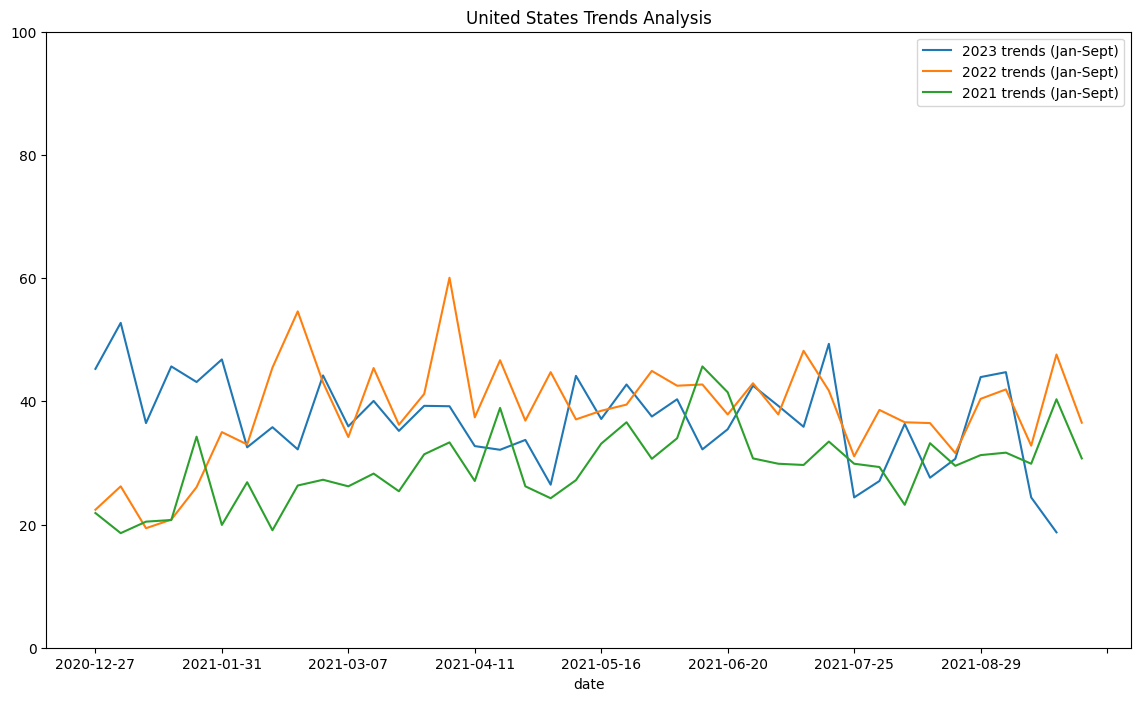

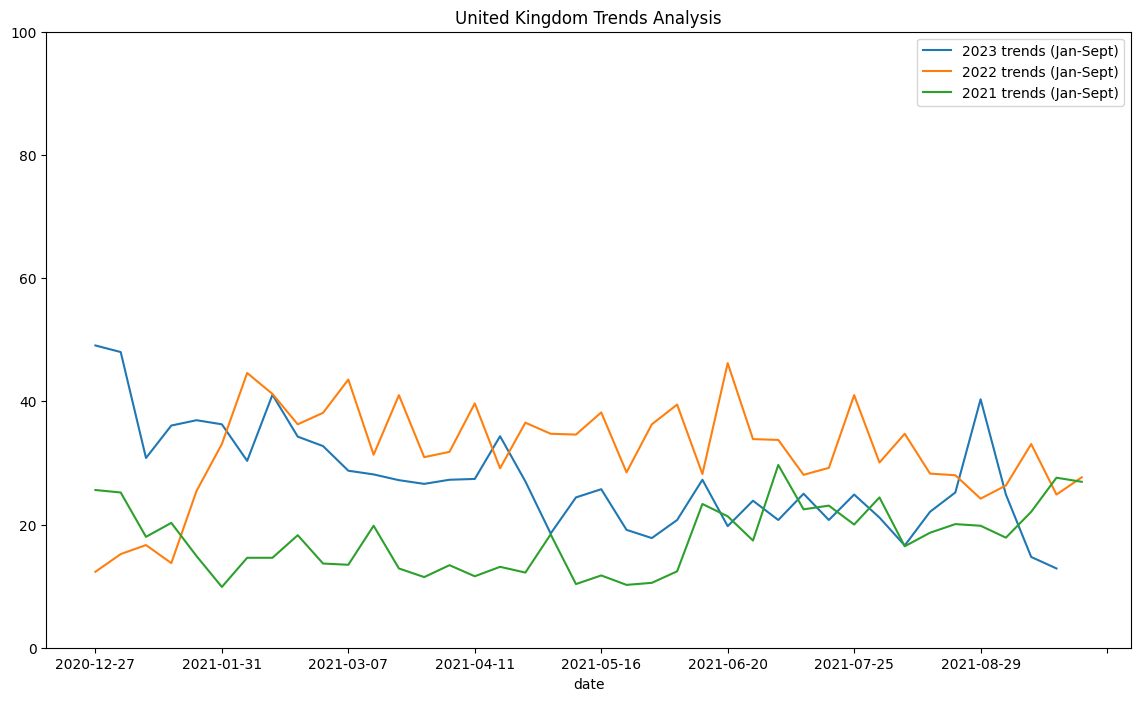

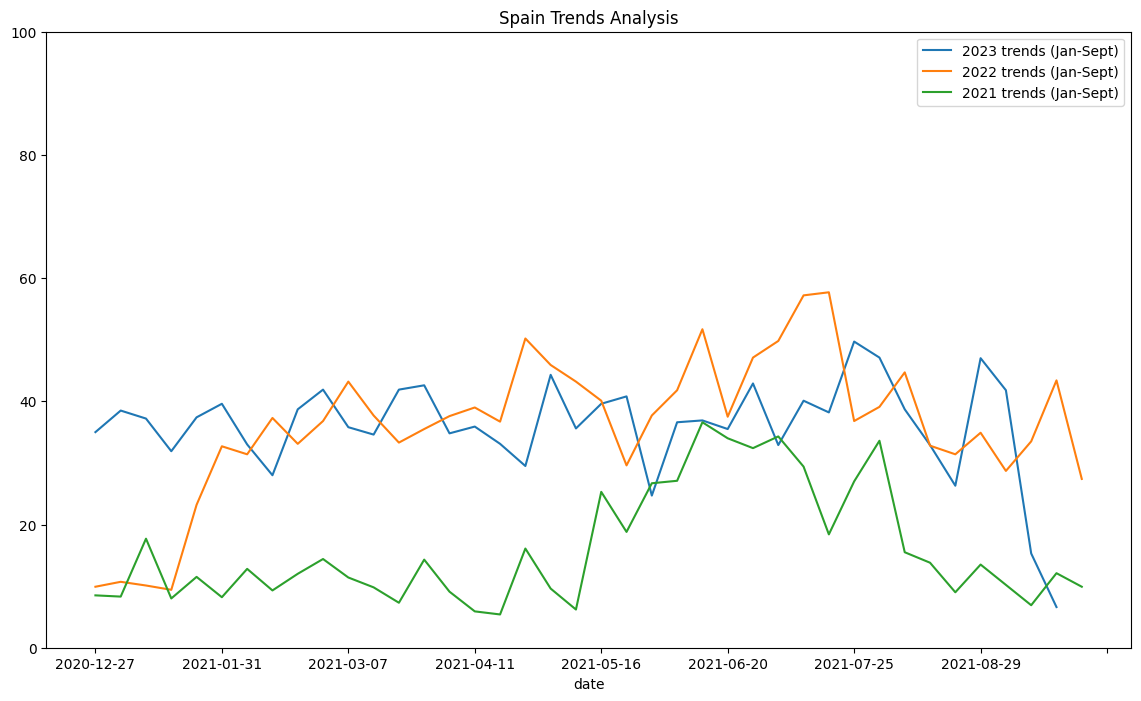

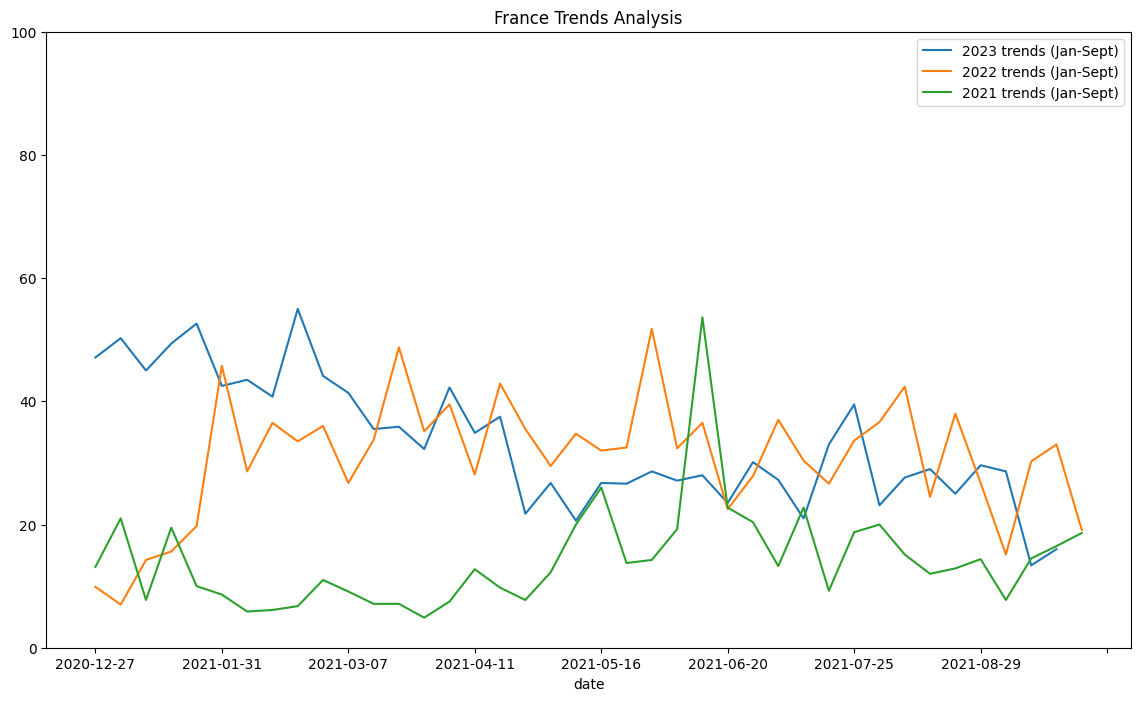

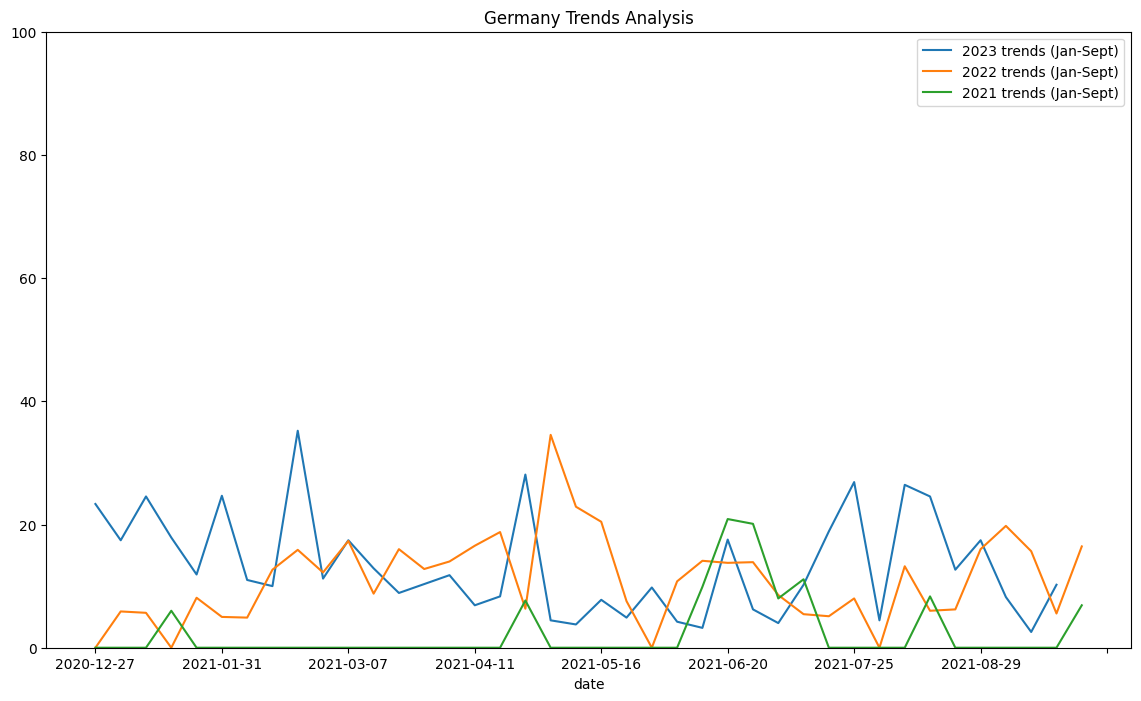

In [21]:
for abbr, name in con_dict.items():
    plot_charts(abbr, df2023[df2023['country']==name], df2022[df2022['country']==name], df2021[df2021['country']==name])

2022 was one of the busiest years for travel in a decade, and the trends in the plots above show that. For 2023, the trends went slightly down, but some months show spikes in searches for travel terms. 

#### Prediction

To predict if tourism will be impacted using Google Trends data,  data points for set query terms from 2019 to latest available date (removing the time periods when the country was under COVID lockdown) were collected.

Specific terms related to flight/hotel cancellation were used, but Google Trends did not have enough data to show that. This prediction is solely based on yearly trends and seasonality. 

In [24]:
def predict_trends(country):
    df1 = get_country_df(country, "2019-01", "2020-03")
    df2 = get_country_df(country, "2021-10", "2023-11")

    df = pd.concat([df1, df2])

    ## Removing effects due to seasonality from the time series
    try:
        result_mul = seasonal_decompose(df.value,model='multiplicative', extrapolate_trend='freq', period = 12)
    except ValueError:
        result_mul = seasonal_decompose(df.value,model='additive', extrapolate_trend='freq', period = 12)
    deseason = df.value - result_mul.seasonal

    ##spilitting the data into train/test set

    Train = pd.DataFrame(deseason[:-60], columns = ['value'])
    valid = pd.DataFrame(deseason[-60:], columns = ['value'])

    ## Fitting the data to Holt's model
    y_hat_avg = pd.DataFrame(valid).copy() 
    fit1 = Holt(np.asarray(Train.value)).fit(smoothing_level = 0.5) #smoothing_level = 0.3, smoothing_slope = 0.1
    y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

    rms = sqrt(mean_squared_error(valid.value, y_hat_avg.Holt_linear)) 
    print(f"RMS error for {con_dict[country]}'s data is {rms:.3f}")

    y_hat_avg['date_ordinal'] = pd.to_datetime(y_hat_avg.index).map(dt.toordinal)
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_hat_avg['date_ordinal'], y_hat_avg['Holt_linear'])

    if slope>0:
        print(f"Upward trend: {slope:.5f}")
    elif slope<0:
        print(f"Downward trend: {slope:.5f}")
    else:
        print("No trend")


    plt.figure(figsize=(20, 8))
    plt.plot(Train['value'], label='training data')
    plt.plot(valid['value'], label='test data') 
    plt.plot(y_hat_avg['Holt_linear'], label='predicted data') 
    plt.legend(loc='best') 
    plt.xticks(rotation = 90, fontsize = 7)
    plt.show()

RMS error for United States's data is 7.810
Downward trend: -0.01134


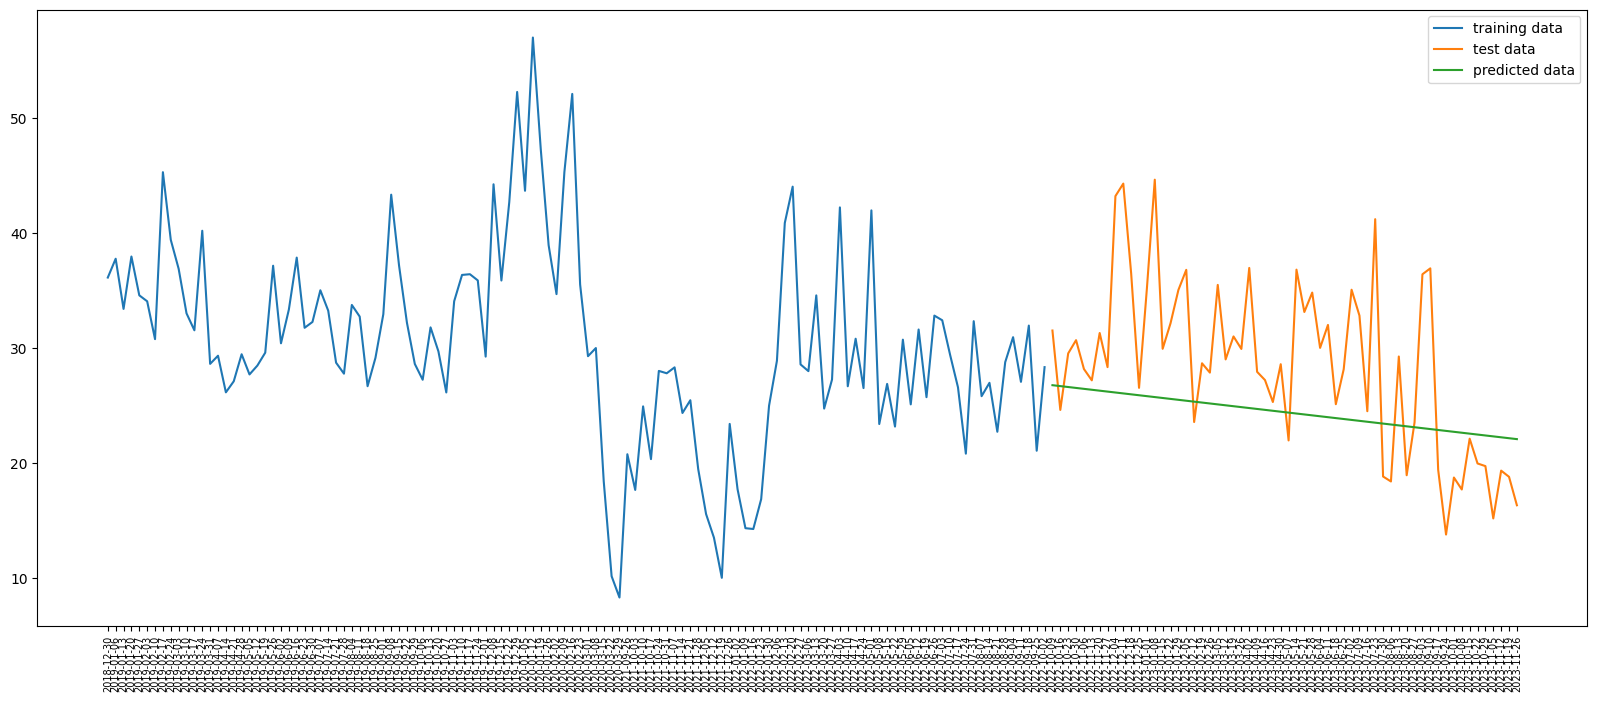

In [25]:
predict_trends("US")

RMS error for Spain's data is 10.025
Upward trend: 0.00197


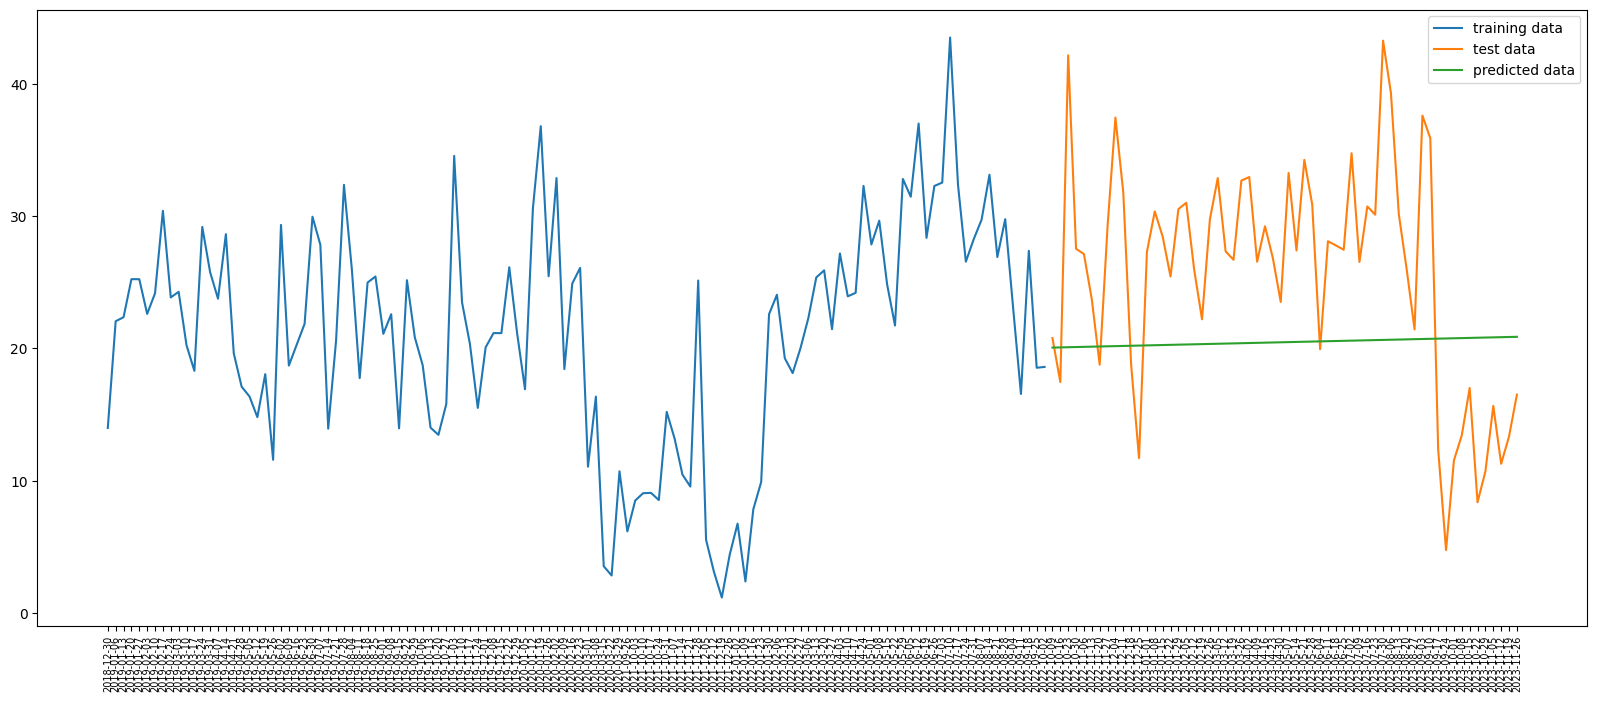

In [26]:
predict_trends("ES")

RMS error for France's data is 7.894
Downward trend: -0.01797


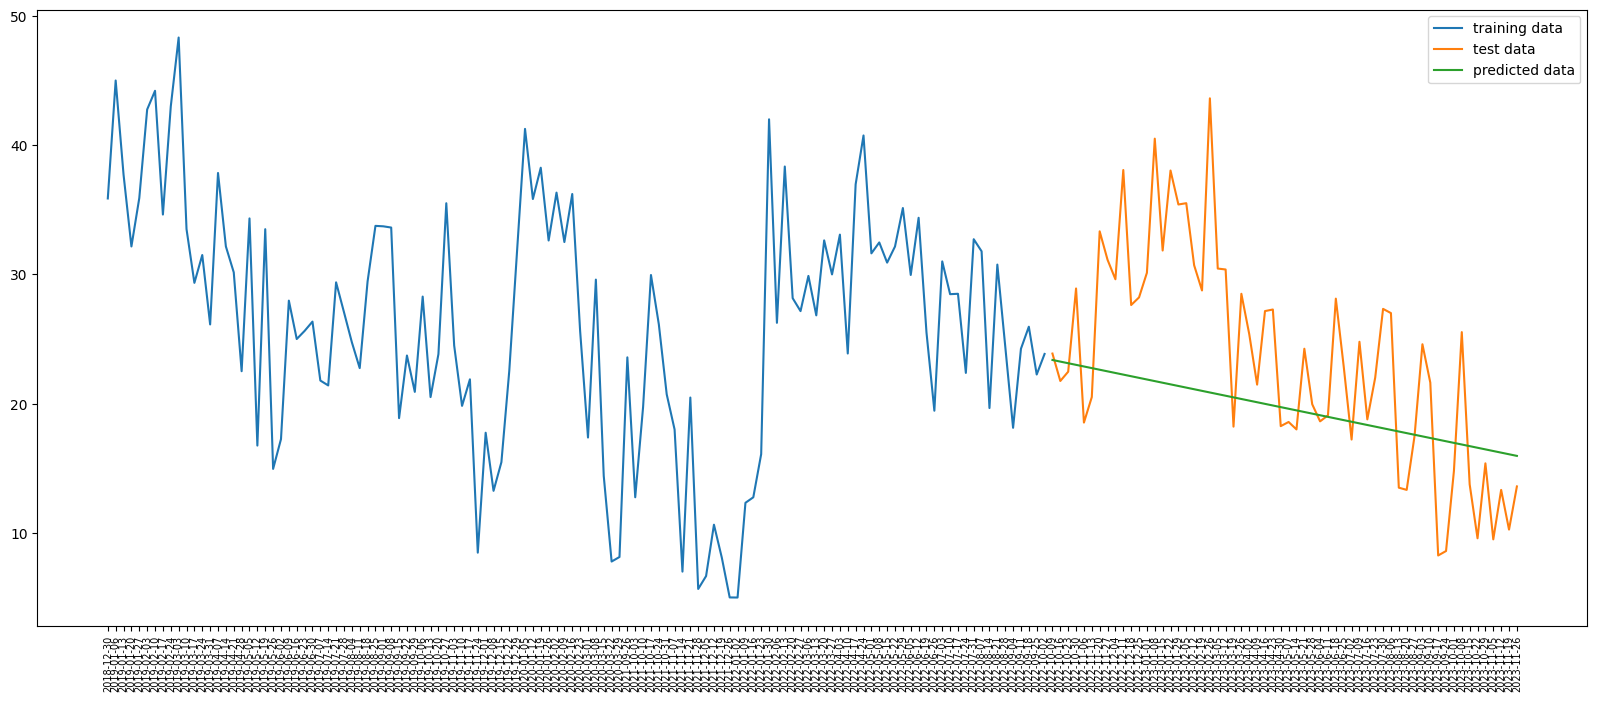

In [27]:
predict_trends("FR")

RMS error for Germany's data is 9.968
Downward trend: -0.01918


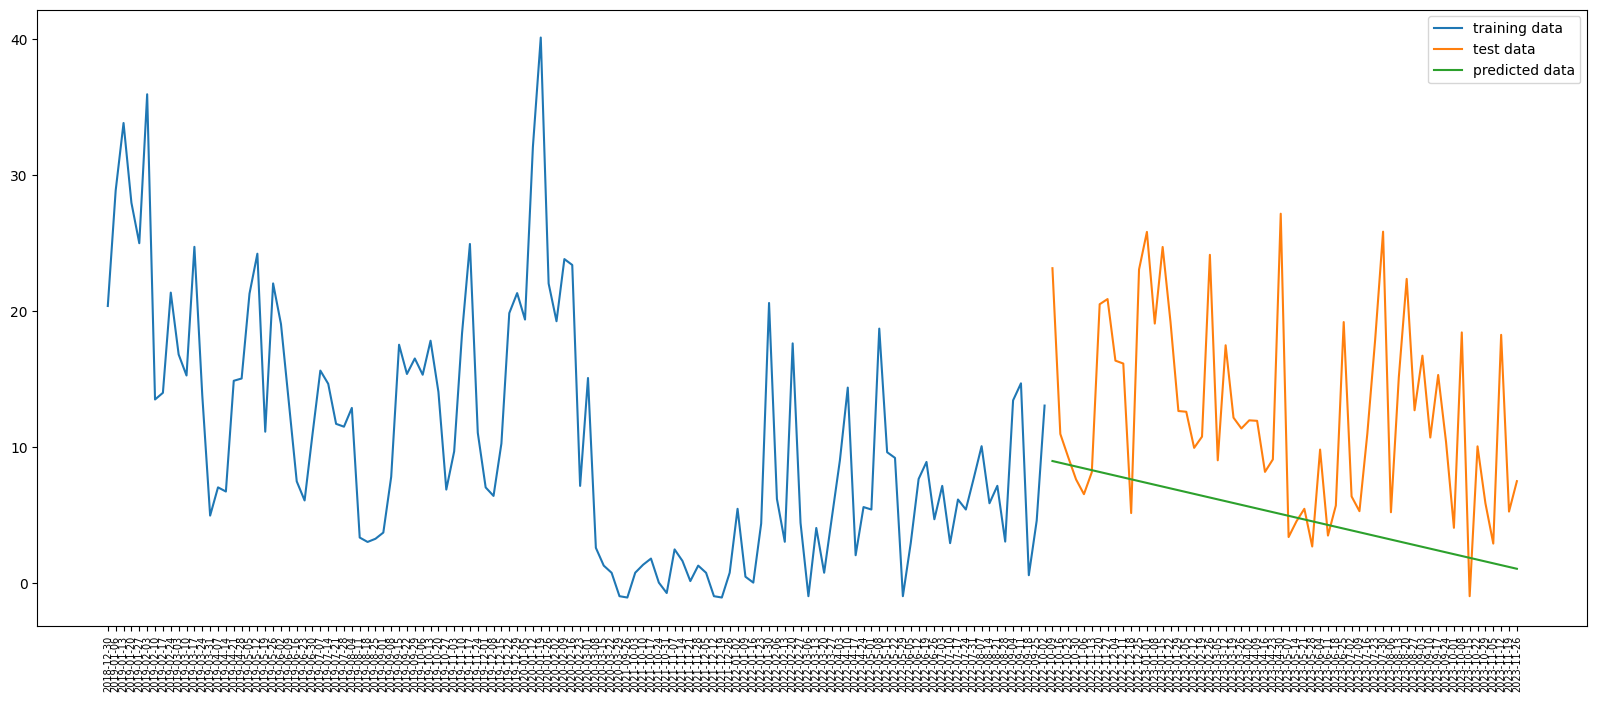

In [28]:
predict_trends("DE")

RMS error for United Kingdom's data is 7.174
Downward trend: -0.00320


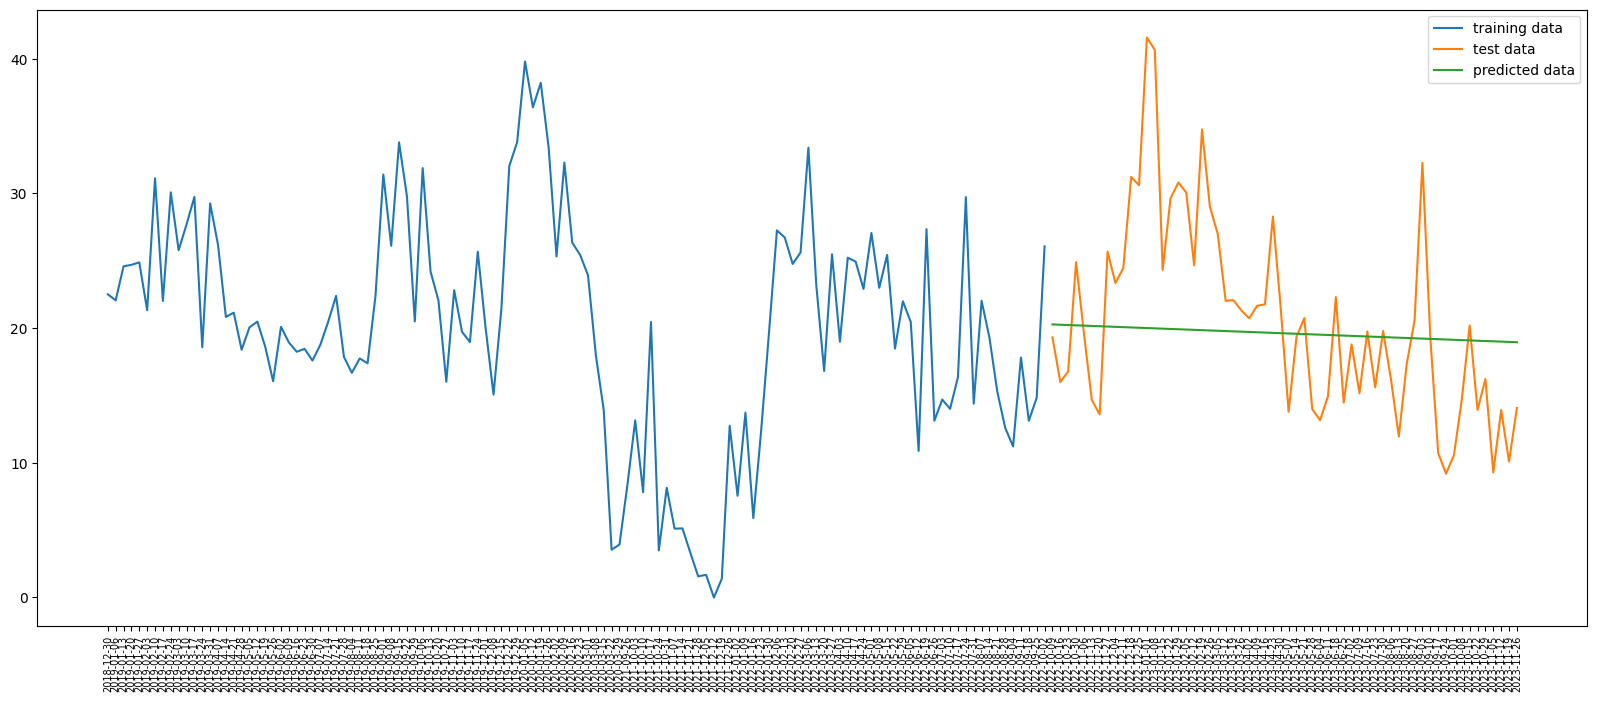

In [29]:
predict_trends("GB")

### Needs Assessment

This part of the analysis uses Google Trends data within Morocco to see if there was a change in the trend of some of the key search terms categories. The search terms comprise of English, French, and Arabic terms that could've been used by the local communities or the search and rescue operations staff. The analysis also takes a deeper dive at the admin regions most affected by the earthquake to see if there's any considerable trend for the search terms.  

In [30]:
water_terms = ['water', 'drinking water', 'يشرب الماء', 'ماء', 'eau']

food_terms = ['grocery store', 'souk', 'خضروات', 'restaurant near me', 'store' ]

ph_terms = ['toilette', 'الحمام', 'toilet']

hosp_terms = ['مستشفى', 'hôpital', 'clinique', 'عيادة', 'hospital', 'clinic', 'medical supply', 'medicines', 'الأدوية']

In [31]:
beq_water = get_df(water_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_water = get_df(water_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_food = get_df(food_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_food = get_df(food_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_ph = get_df(ph_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_ph = get_df(ph_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_hosp = get_df(hosp_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_hosp = get_df(hosp_terms, 'MA', start_date='2023-09', end_date = '2023-09')

In [32]:
def plot_needs_trends(before, after, keyword, region = None):
    plt.figure(figsize=(16, 6))
    before_agg = before.groupby(['date'])[['value']].mean()
    after_agg = after.groupby(['date'])[['value']].mean()
    result_bef = np.polyfit(pd.factorize(before_agg.index)[0], list(before_agg.value), 1)
    trendpoly_bef = np.poly1d(result_bef) 
    result_aft = np.polyfit(pd.factorize(after_agg.index)[0], list(after_agg.value), 1)
    trendpoly_aft = np.poly1d(result_aft) 
    plt.plot(before_agg['value'], label='Before Earthquake')
    plt.plot(before_agg.index, trendpoly_bef(pd.factorize(before_agg.index)[0]), label = 'Trendline - Before Earthquake')
    plt.plot(after_agg['value'], label='After Earthquake')
    plt.plot(after_agg.index, trendpoly_aft(pd.factorize(after_agg.index)[0]), label = 'Trendline - After Earthquake')
    plt.xticks(rotation = 90, fontsize = 7);
    plt.ylabel("Scaled Search Results Score", fontsize = 12)
    if region:
        plt.title(f"Search trends for {keyword} related keywords before and after the earthquake in {region} region")
    else:
        plt.title(f"Search trends for {keyword} related keywords before and after the earthquake")
    plt.legend(loc='best');
    plt.show()

In [33]:
def get_needs_trends(df):
    df_grp = df.groupby(['date'])[['value']].mean()

    stat = trenddetector(pd.factorize(df_grp.index)[0], df_grp.value)

    if stat>0:
        print(f"Upward trend: {stat}")
    elif stat<0:
        print(f"Downward trend: {stat}")
    else:
        print("No trend")

First, we analyze the trends of search keywords for before and after the earthquake period for Morocco. At the national level, we do not observe a significant change in the search trends.  

Trends for before earthquake period of water terms
Downward trend: -0.009045352673062848
Trends for after earthquake period of water terms
Downward trend: -0.03261401557285964


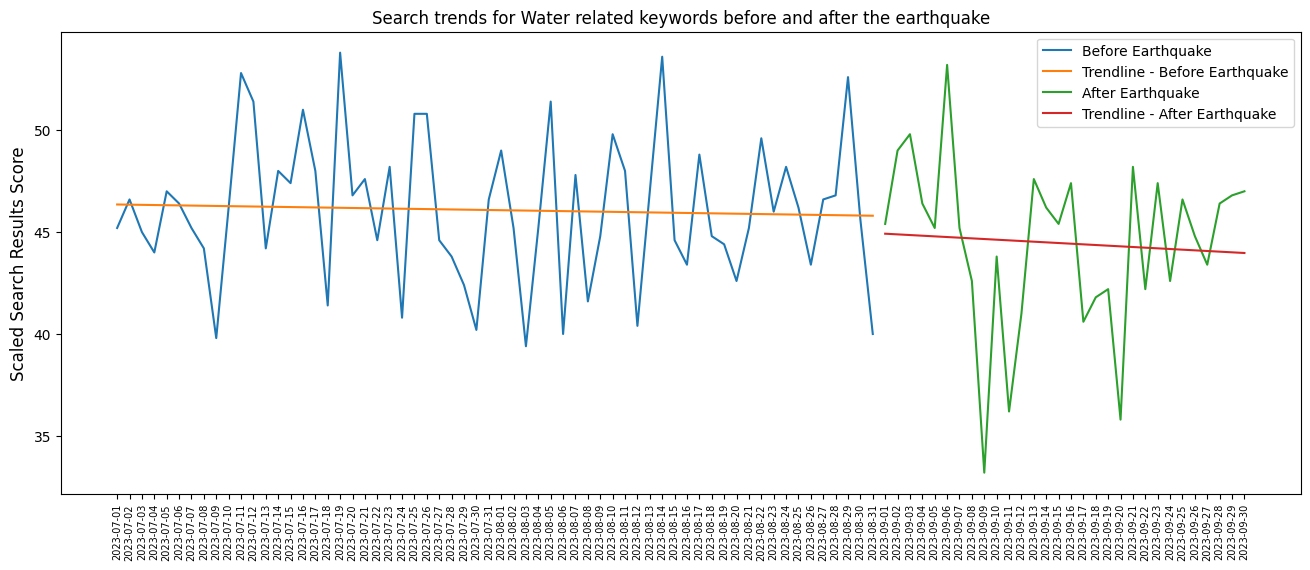

In [43]:
print("Trends for before earthquake period of water terms")
get_needs_trends(beq_water)
print("Trends for after earthquake period of water terms")
get_needs_trends(aeq_water)
plot_needs_trends(beq_water, aeq_water, 'Water')

Trends for before earthquake period of food terms
Upward trend: 0.019455566467728967
Trends for after earthquake period of food terms
Downward trend: -0.1265406006674088


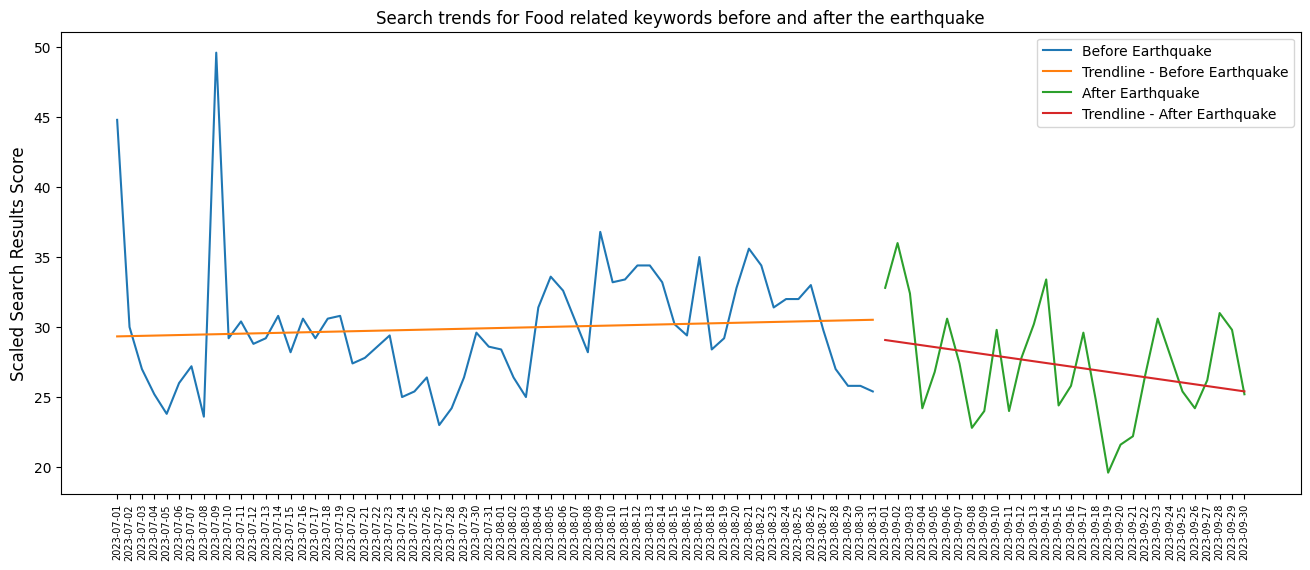

In [44]:
print("Trends for before earthquake period of food terms")
get_needs_trends(beq_food)
print("Trends for after earthquake period of food terms")
get_needs_trends(aeq_food)
plot_needs_trends(beq_food, aeq_food, 'Food')

Trends for before earthquake period of personal hygiene terms
Upward trend: 0.0461836770668073
Trends for after earthquake period of personal hygiene terms
Upward trend: 0.10967741935483752


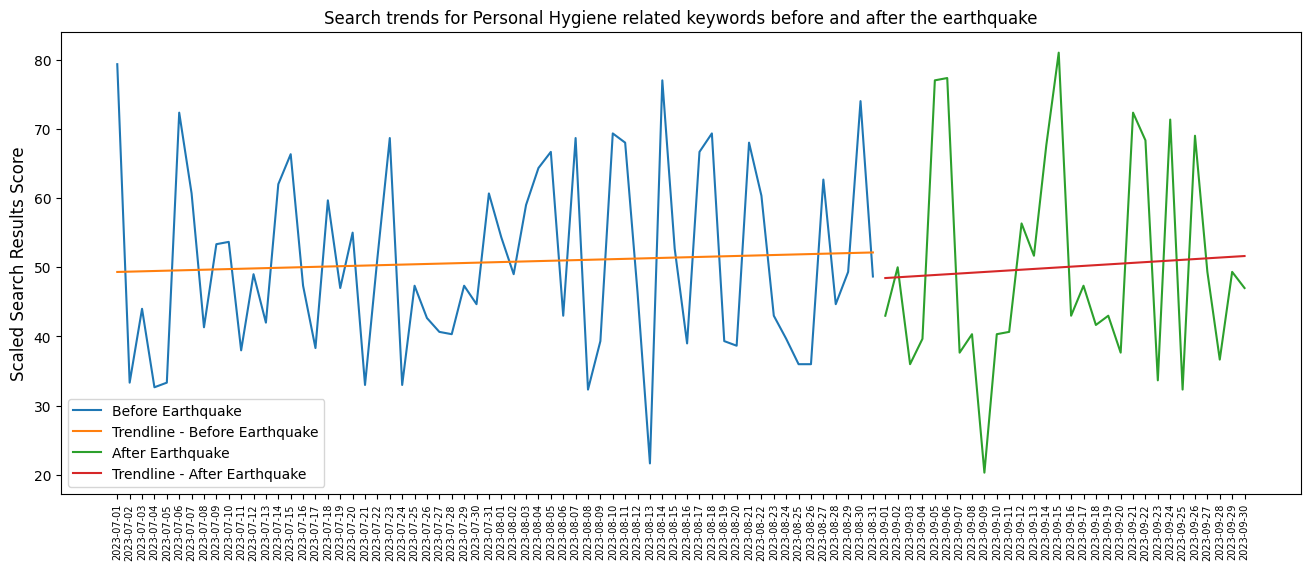

In [45]:
print("Trends for before earthquake period of personal hygiene terms")
get_needs_trends(beq_ph)
print("Trends for after earthquake period of personal hygiene terms")
get_needs_trends(aeq_ph)
plot_needs_trends(beq_ph, aeq_ph, 'Personal Hygiene')

Trends for before earthquake period of hospital terms
Downward trend: -0.12651406411321814
Trends for after earthquake period of hospital terms
Upward trend: 0.028896304535903285


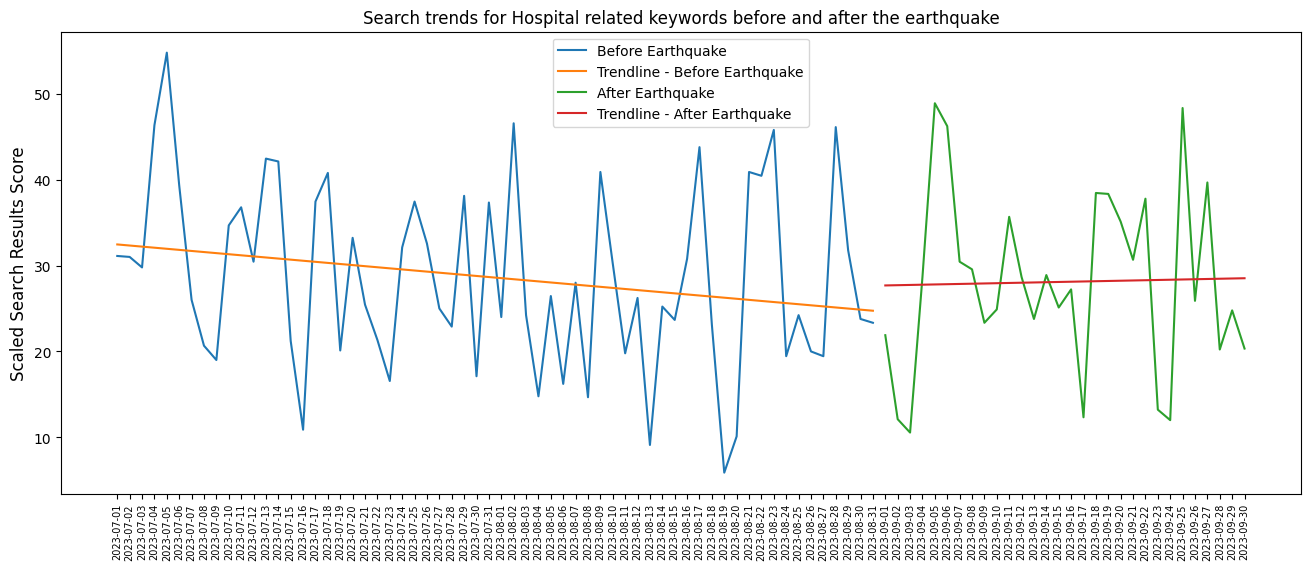

In [46]:
print("Trends for before earthquake period of hospital terms")
get_needs_trends(beq_hosp)
print("Trends for after earthquake period of hospital terms")
get_needs_trends(aeq_hosp)
plot_needs_trends(beq_hosp, aeq_hosp, 'Hospital')

##### Analyzing data at subnational regions for impacted areas

Béni Mellal-Khénifra Region

Trends for Béni Mellal-Khénifra before earthquake period of water terms
Downward trend: -0.06971871773564
Trends for Béni Mellal-Khénifra after earthquake period of water terms
Upward trend: 0.1005116796440489


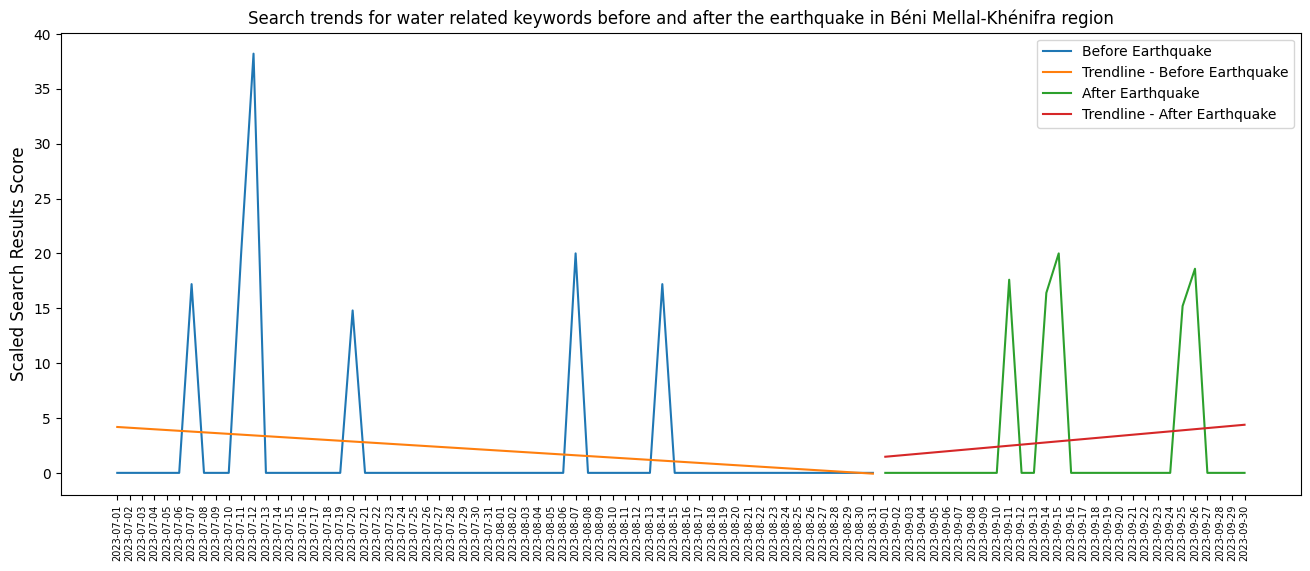

============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of food terms
Downward trend: -0.030329127949434608
Trends for Béni Mellal-Khénifra after earthquake period of food terms
Upward trend: 0.2434705228031145


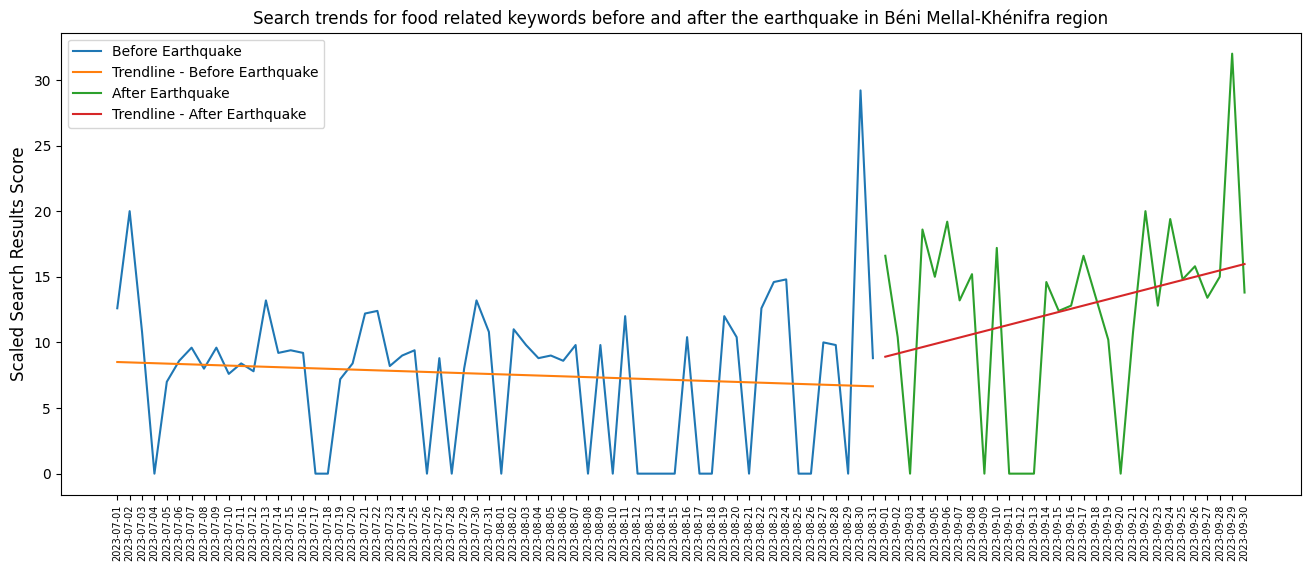

============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of personal hygiene terms
No trend
Trends for Béni Mellal-Khénifra after earthquake period of personal hygiene terms
Downward trend: -0.1853911753800521


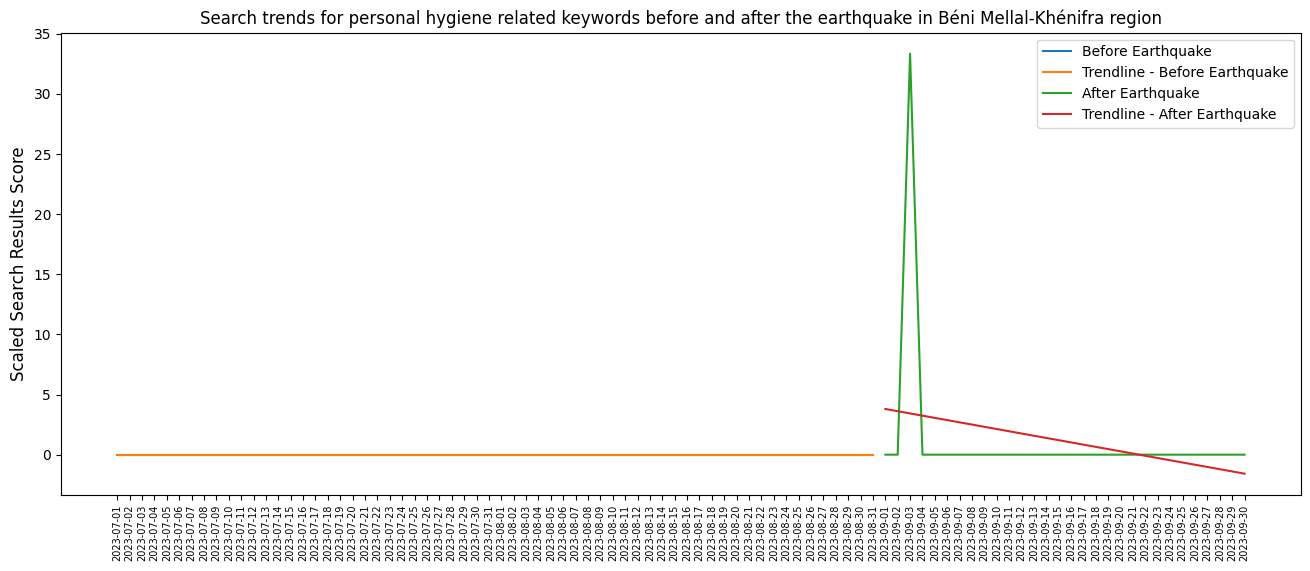

============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of hospital terms
Downward trend: -0.06382782268556994
Trends for Béni Mellal-Khénifra after earthquake period of hospital terms
Upward trend: 0.08130021010999876


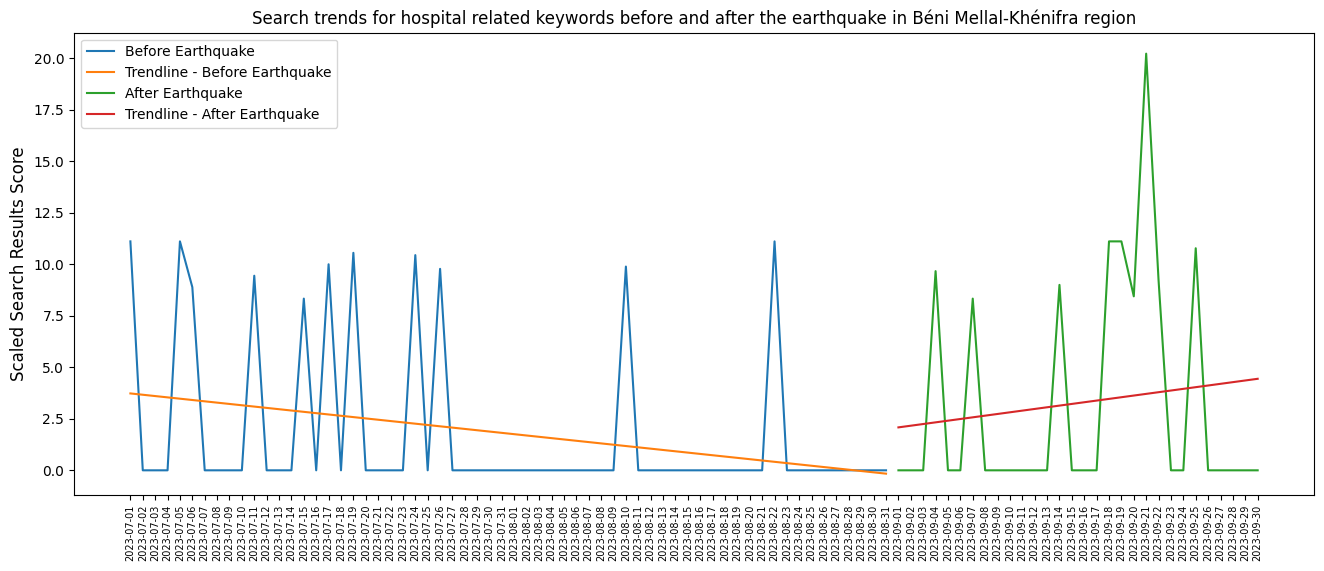

============*****=================


In [47]:
needs_terms = {"water" : water_terms, "food" : food_terms, "personal hygiene" : ph_terms, "hospital" : hosp_terms}

for terms in needs_terms.keys():
    bef = get_df(needs_terms[terms], "MA-05", start_date='2023-07', end_date = "2023-08")
    aft = get_df(needs_terms[terms], "MA-05", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Béni Mellal-Khénifra before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Béni Mellal-Khénifra after earthquake period of {terms} terms")
    get_needs_trends(aft)
    plot_needs_trends(bef, aft, terms, 'Béni Mellal-Khénifra')
    print("============*****=================")

Marrakech-Safi Region

Trends for Marrakech-Safi Region before earthquake period of water terms
Downward trend: -0.04599733071441194
Trends for Marrakech-Safi Region after earthquake period of water terms
Upward trend: 0.0025806451612901617


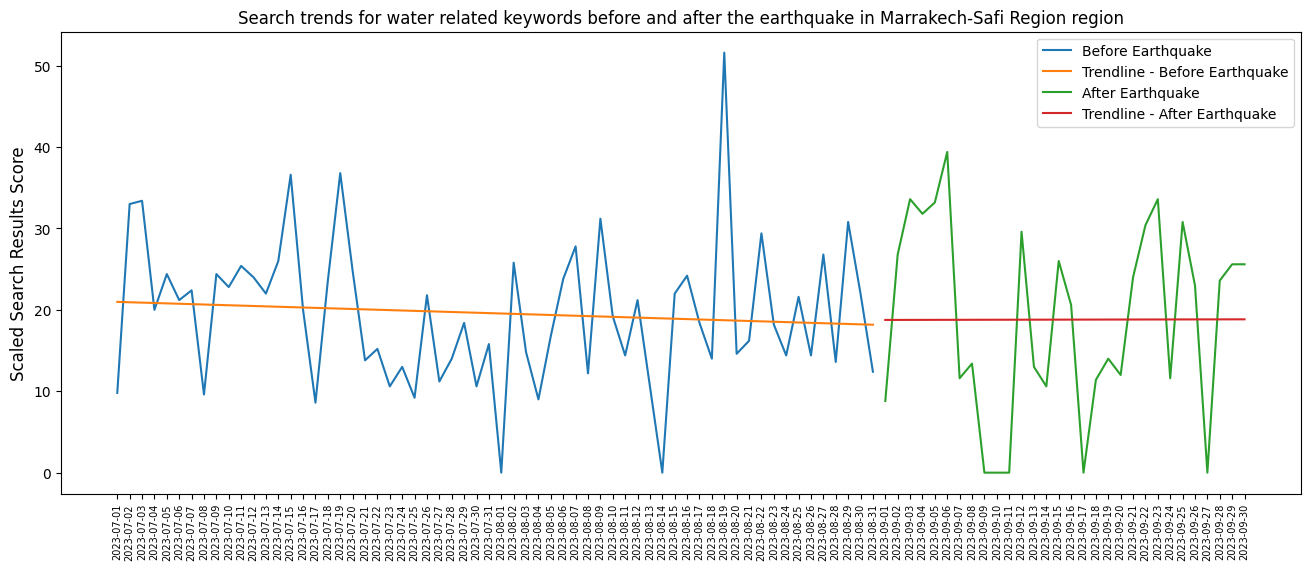

============*****=================
Trends for Marrakech-Safi Region before earthquake period of food terms
Downward trend: -0.03227317367983696
Trends for Marrakech-Safi Region after earthquake period of food terms
Upward trend: 0.10095661846496075


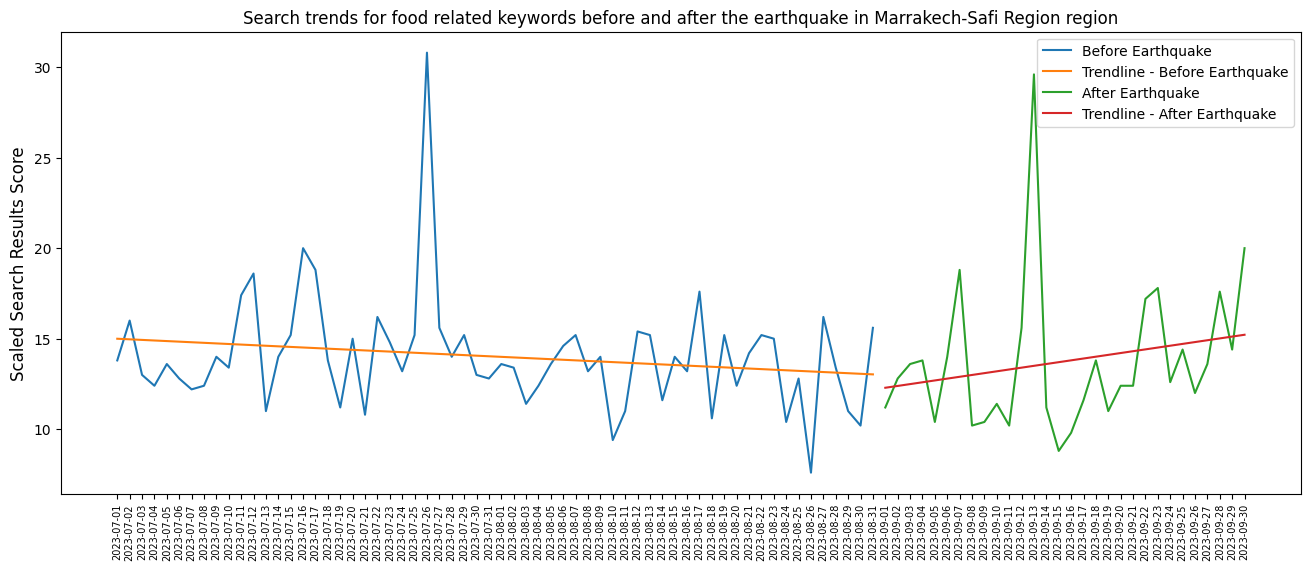

============*****=================
Trends for Marrakech-Safi Region before earthquake period of personal hygiene terms
Upward trend: 0.005464480874316922
Trends for Marrakech-Safi Region after earthquake period of personal hygiene terms
Downward trend: -0.02224694104560624


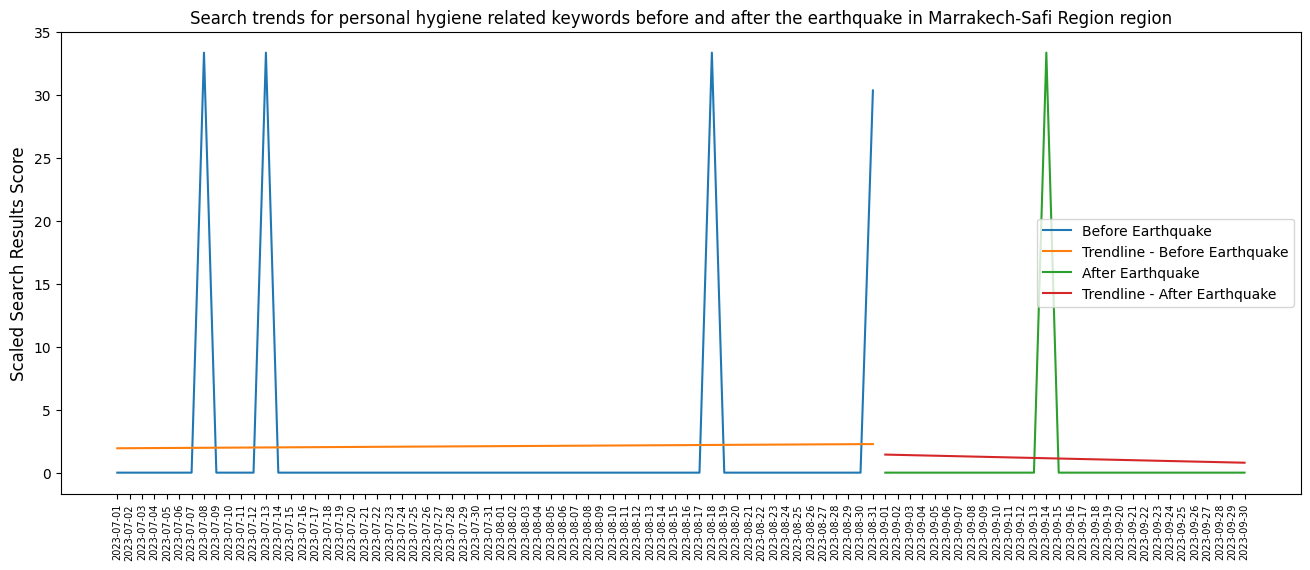

============*****=================
Trends for Marrakech-Safi Region before earthquake period of hospital terms
Downward trend: -0.03399561834252485
Trends for Marrakech-Safi Region after earthquake period of hospital terms
Downward trend: -0.1000370782350763


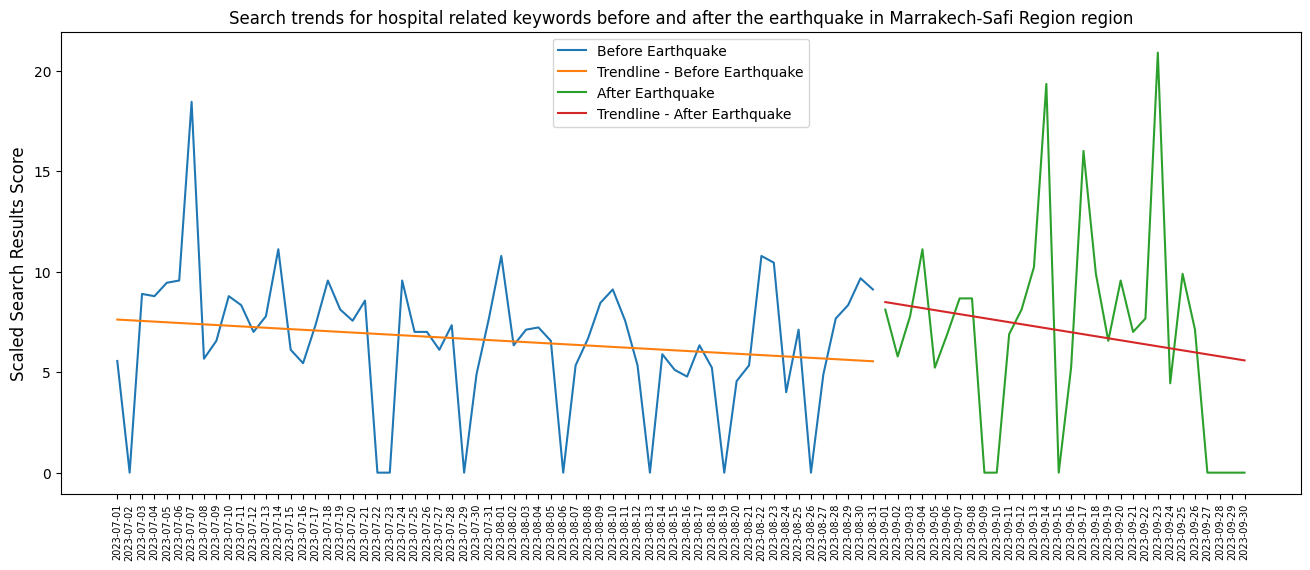

============*****=================


In [48]:
needs_terms = {"water" : water_terms, "food" : food_terms, "personal hygiene" : ph_terms, "hospital" : hosp_terms}

for terms in needs_terms.keys():
    bef = get_df(needs_terms[terms], "MA-07", start_date='2023-07', end_date = "2023-08")
    aft = get_df(needs_terms[terms], "MA-07", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Marrakech-Safi Region before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Marrakech-Safi Region after earthquake period of {terms} terms")
    get_needs_trends(aft)
    plot_needs_trends(bef, aft, terms, 'Marrakech-Safi Region')
    print("============*****=================")

Souss-Massa Region

Trends for Souss-Massa Region before earthquake period of water terms
Upward trend: 0.028712447432701255
Trends for Souss-Massa Region after earthquake period of water terms
Upward trend: 0.27083426028921026


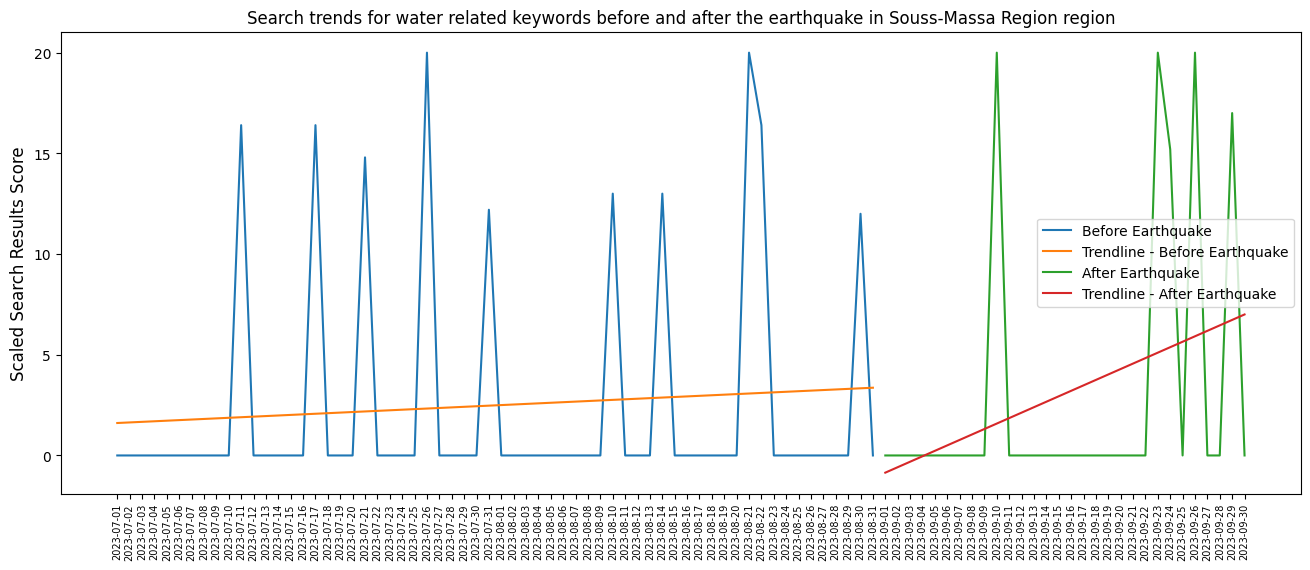

============*****=================
Trends for Souss-Massa Region before earthquake period of food terms
Downward trend: -0.05153735740726758
Trends for Souss-Massa Region after earthquake period of food terms
Downward trend: -0.05477196885428272


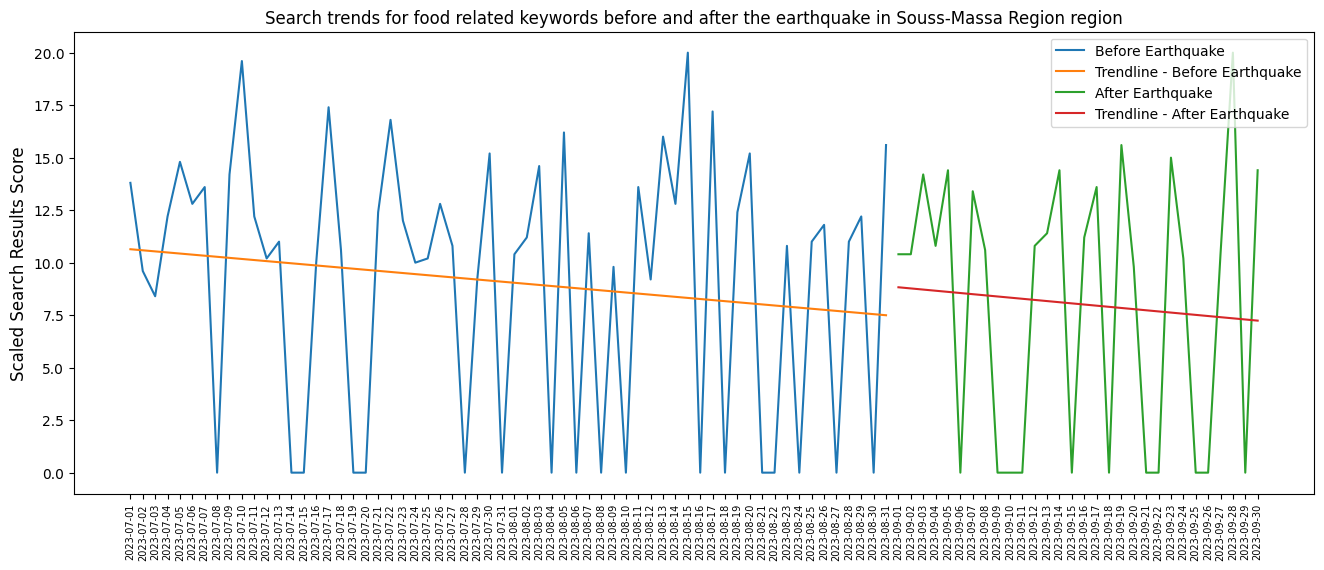

============*****=================
Trends for Souss-Massa Region before earthquake period of personal hygiene terms
Upward trend: 0.034415317334407766
Trends for Souss-Massa Region after earthquake period of personal hygiene terms
Upward trend: 0.27771598071931786


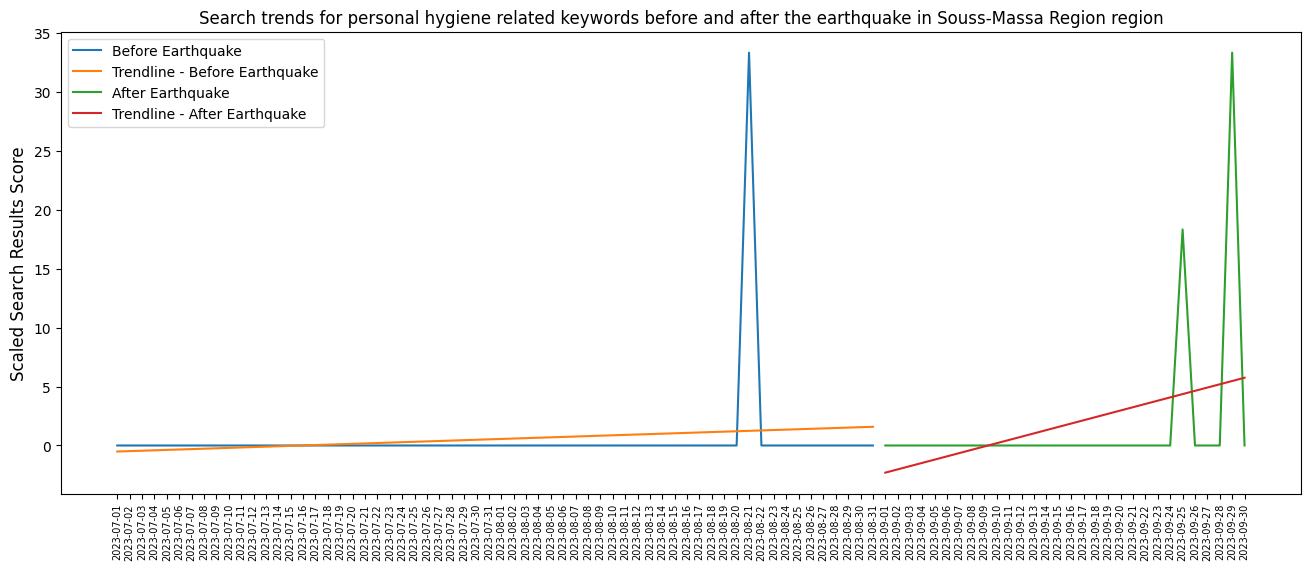

============*****=================
Trends for Souss-Massa Region before earthquake period of hospital terms
Upward trend: 0.004110252127174388
Trends for Souss-Massa Region after earthquake period of hospital terms
Downward trend: -0.0620195278704734


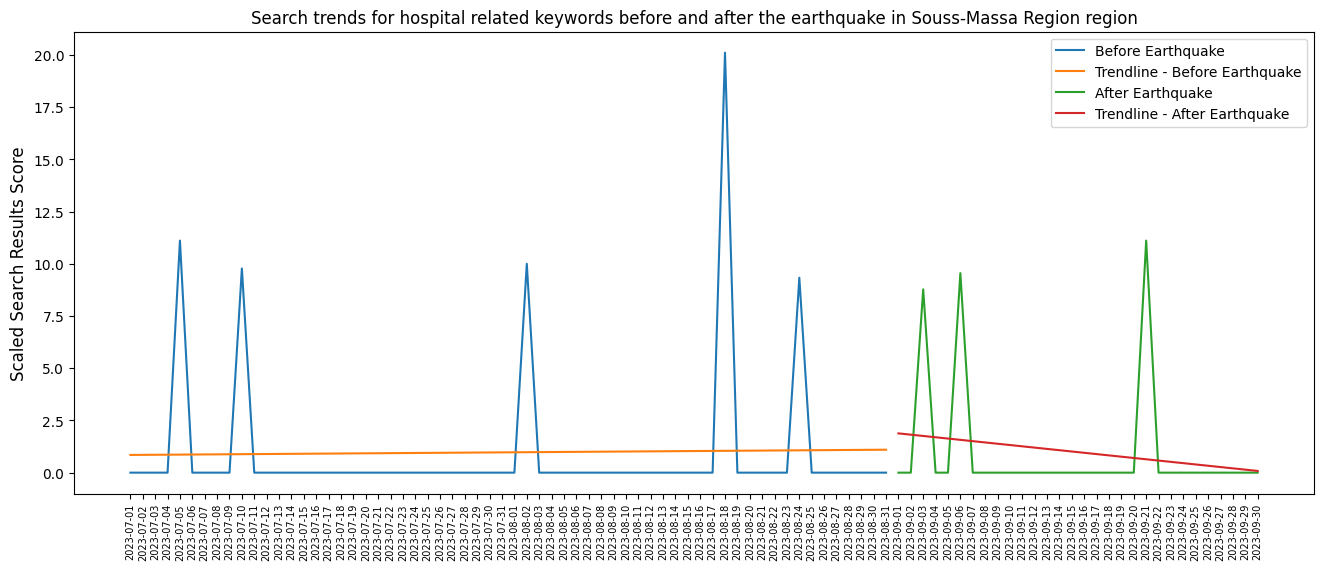

============*****=================


In [49]:
needs_terms = {"water" : water_terms, "food" : food_terms, "personal hygiene" : ph_terms, "hospital" : hosp_terms}

for terms in needs_terms.keys():
    bef = get_df(needs_terms[terms], "MA-09", start_date='2023-07', end_date = "2023-08")
    aft = get_df(needs_terms[terms], "MA-09", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Souss-Massa Region before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Souss-Massa Region after earthquake period of {terms} terms")
    get_needs_trends(aft)
    plot_needs_trends(bef, aft, terms, 'Souss-Massa Region')
    print("============*****=================")

## Practice
Using Google Trends Free Tool:
- Search the trend for Gel Alcohol worldwide since 2004 till today.
- Which is the country with the highest interest in the term?